# SN II Template

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import piscola

In [2]:
info_df = pd.read_csv('templates/he4_list', 
                      names=['phase', 'file'], delim_whitespace=True, comment='#')

columns = ['wave', 'flux']
df_list = []
for phase, file in info_df.values:
    temp_file = os.path.join('templates', f'{file}.fl')
    epoch_df = pd.read_csv(temp_file, names=columns, delim_whitespace=True)
    epoch_df['phase'] = phase
    df_list.append(epoch_df)
init_sed_df = pd.concat(df_list)
init_sed_df = init_sed_df[(init_sed_df.wave >= 1000) & (init_sed_df.wave <= 12000)]  # remove most of the UV and IR 

In [3]:
# linearly interpolate to a common wavelength array taking the first epoch as reference 
phase_df0 = init_sed_df[init_sed_df.phase==init_sed_df.phase.values[0]]
wave0 = phase_df0.wave.values

interp_list = []
for phase in init_sed_df.phase.unique():
    phase_df = init_sed_df[init_sed_df.phase==phase]
    interp_flux = np.interp(wave0, phase_df.wave.values, phase_df.flux.values)
    interp_df = pd.DataFrame({'wave':wave0, 'flux':interp_flux, 'phase':phase})
    interp_list.append(interp_df)
    
sed_df = pd.concat(interp_list)

Template from: https://ui.adsabs.harvard.edu/abs/2020A%26A...642A.106D/abstract

Note that these models use a strong chemical (boxcar) mixing.
This likely leads to an overestimate of line widths for all species,
i.e. HeI lines because 56Ni is present far out, but also of IMEs since 
their abundance is also enhanced at large V.

Models he4-he8 (he10-he12) correspond to SNe Ib (Ic) progenitors. Model he9 is an interme-
diate case.

## SED template

This SN II SED template has phases with respect to explosion epoch 

,wave,flux,phase
0,1000.087,2.115447e-09,3.84
1,1001.109,2.076044e-09,3.84
2,1002.142,2.133766e-09,3.84
3,1003.168,2.270727e-09,3.84
4,1004.200,2.358311e-09,3.84


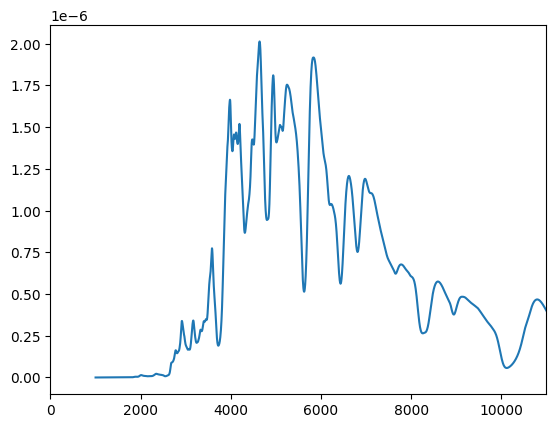

In [4]:
phase_df = sed_df[sed_df.phase==10.930]
plt.plot(phase_df.wave, phase_df.flux)
plt.xlim(0, 11000);
sed_df.head()

## B-band peak

Let's get offset of the template phase to estimate a new phase with respect to B-band peak

In [5]:
Bessell_B = piscola.filters_class.SingleFilter('Bessell_B', 'VEGA')

fluxes_B = []
for phase in sed_df.phase.unique():
    phase_df = sed_df[sed_df.phase==phase]
    flux = Bessell_B.integrate_filter(phase_df.wave.values, phase_df.flux.values)
    fluxes_B.append(flux)
fluxes_B = np.array(fluxes_B)

Text(0.5, 1.0, 'B-band light curve')

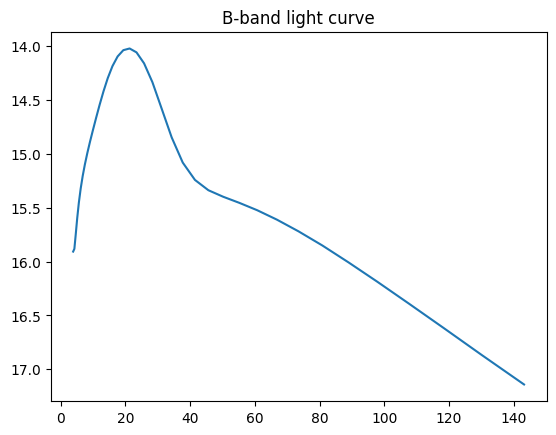

In [6]:
plt.plot(sed_df.phase.unique(), -2.5*np.log10(fluxes_B))
plt.gca().invert_yaxis()
plt.title('B-band light curve')

In [7]:
peak_id = np.argmax(fluxes_B)
peak_offset = sed_df.phase.unique()[peak_id]
peak_offset

21.29

## Interpolate SED

In [17]:
interp_dict = {'phase':np.empty(0),
               'wave':np.empty(0),
               'flux':np.empty(0),
              }

waves = sed_df.wave.unique()
interp_phases = np.arange(-20, 100)

for wave in waves:
    lc_df = sed_df[sed_df.wave==wave]
    lc_phase, lc_flux = lc_df.phase.values- peak_offset, lc_df.flux.values
    interp_flux = np.interp(interp_phases, lc_phase, lc_flux)
    
    interp_wave = np.array([wave]*len(interp_phases))
    interp_dict['phase'] = np.append(interp_dict['phase'], interp_phases)
    interp_dict['wave'] = np.append(interp_dict['wave'], interp_wave)
    interp_dict['flux'] = np.append(interp_dict['flux'], interp_flux)
    
interp_df = pd.DataFrame(interp_dict)
interp_df.sort_values(['phase', 'wave'], inplace=True)
# apply offset to phase to have epochs with respect to B-band peak
# instead of epochs with respect to explosion epoch
interp_df.phase = interp_df.phase.values 

Plot the result

,phase,wave,flux
0,-20.0,1000.087,2.115447e-09
120,-20.0,1001.109,2.076044e-09
240,-20.0,1002.142,2.133766e-09
360,-20.0,1003.168,2.270727e-09
480,-20.0,1004.200,2.358311e-09


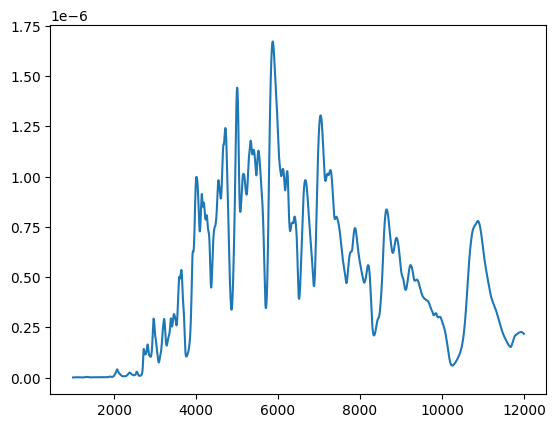

In [18]:
# SED
phase_df = interp_df[interp_df.phase==20]
plt.plot(phase_df.wave, phase_df.flux);
interp_df.head()

Text(0.5, 1.0, 'B-band light curve')

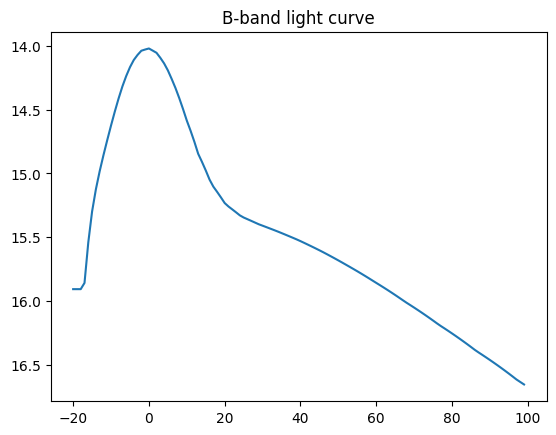

In [19]:
# Light curve
Bessell_B = piscola.filters_class.SingleFilter('Bessell_B', 'VEGA')

fluxes_B = []
for phase in interp_df.phase.unique():
    phase_df = interp_df[interp_df.phase==phase]
    flux = Bessell_B.integrate_filter(phase_df.wave.values, phase_df.flux.values)
    fluxes_B.append(flux)
fluxes_B = np.array(fluxes_B)

plt.plot(interp_df.phase.unique(), -2.5*np.log10(fluxes_B))
plt.gca().invert_yaxis()
plt.title('B-band light curve')

## Output

Save the template for PISCOLA to read and create a README file

In [20]:
interp_df.to_csv('sed_template.dat', index=False, sep='\t', header=False)

In [21]:
readme = """This template is a modified version of the Dessart et al. (2020),
given by Luc himself.

The original template is linearly interpolated in time and
the phases are shifted such that the Bessell-B-band light-curve
peak is taken as phase 0 (zero).
"""

In [22]:
with open('README.txt', 'w') as file:
    file.write(readme)